<a href="https://colab.research.google.com/github/Dforouzanfar/Text_Mining_and_Sentiment_Analysis/blob/master/ProjectHateYouModular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preliminary Setup

## 0.1. Helper functions

In [1]:
!git clone https://github.com/Dforouzanfar/Text_Mining_and_Sentiment_Analysis
!mv Text_Mining_and_Sentiment_Analysis/GoingModular .
!rm -rf Text_Mining_and_Sentiment_Analysis

Cloning into 'Text_Mining_and_Sentiment_Analysis'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 15), reused 38 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 353.74 KiB | 1.56 MiB/s, done.
Resolving deltas: 100% (15/15), done.


## 0.2. Required Libraries

In [2]:
!pip install -q contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
from GoingModular.CreateDirectories import CreateDirectories
from GoingModular.DataManager import DataManager
from GoingModular.TextPreprocessor import TextPreprocessor
from GoingModular.Vectorizer import Vectorizer
from GoingModular.ModelTrainer import ModelTrainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 0.3. Loading a Pretrained Word2Vec Model

In [4]:
pretrain_wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## 0.4. Creating directory

In [5]:
from GoingModular.CreateDirectories import CreateDirectories

CreateDirectories("Data")

Directory 'Data' created successfully!


# 1. Data

In [6]:
from GoingModular.DataManager import DataManager

data_manager = DataManager(data_path="Data", file_name="hate_speech.csv")
data_manager.download_data(url="https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv")
data_manager.load_data()

Dataset downloaded!
Data loaded and balanced successfully!


## 1.1. Data Exploration

<font size='4'>Labels:
<li>0: Neither</li>
<li>1: Hate</li>
<li>2: Offensive</li>
</font>

In [7]:
raw_df = data_manager.raw_df

# Some basic info about the dataset
print(f"Shape of the dataset:\n{raw_df.shape}\n-\nNull Values:\n{raw_df.isna().any()}\n-\nData Types:\n{raw_df.dtypes}\n-\nValue Counts for labels:\n{raw_df['Label'].value_counts()}")

Shape of the dataset:
(4290, 2)
-
Null Values:
Label    False
Text     False
dtype: bool
-
Data Types:
Label     int64
Text     object
dtype: object
-
Value Counts for labels:
Label
0    1430
2    1430
1    1430
Name: count, dtype: int64


In [8]:
# 4 samples of text and their labels
raw_df.sample(n=4)

,Label,Text
1340,0,@geokthree I literally just told @Black_SinS t...
39,0,I'll give you a baby zebra girl.
1251,0,@RubyFakhoury @Nyquil_Dreams @guynamedjordan l...
1754,2,Say it's all about the hoes when it's all abou...


In [9]:
raw_df["Text"].loc[887]

'When did Miley turn ghetto?'

In [10]:
df = raw_df.copy()

# Number of character per text
df["char_count"] = df["Text"].apply(lambda x: len(x))
char_mean = np.mean(df["char_count"])

# Find the indices of the ten rows with the highest values in 'char_count'
indices_to_remove = df['char_count'].nlargest(10).index

# Drop those rows and reset the index
df = df.drop(index=indices_to_remove).reset_index(drop=True)

print(f"Min: {df['char_count'].min()} | Average: {char_mean:<0.3f} | Max: {df['char_count'].max()}")

Min: 5 | Average: 87.514 | Max: 199


In [11]:
print(f"The text that has the min amount of char: {df['Text'].loc[df['char_count'].idxmin()]}")

The text that has the min amount of char: coons


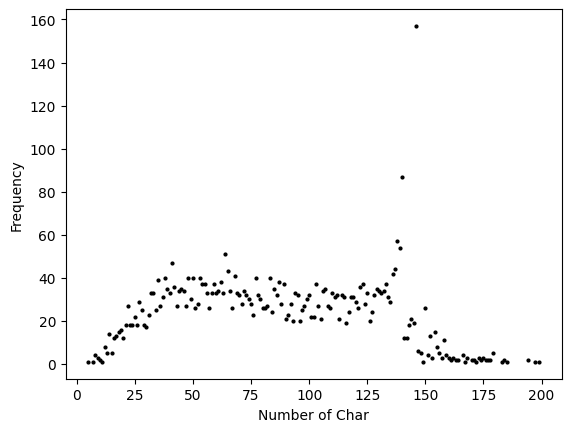

In [12]:
# Calculate the frequency of each character count and sort by index
char_count = df["char_count"].value_counts().sort_index()

# Create a scatter plot of character counts versus their frequencies
plt.plot(char_count.index, char_count.values, 'o', markersize=2, color='black')
plt.xlabel("Number of Char")
plt.ylabel("Frequency")

plt.show()

In [13]:
max_freq = char_count.values.max()
char_count = char_count.index[char_count.values == max_freq][0]
print(f"There are {max_freq} texts with a length of {char_count} chars")

There are 157 texts with a length of 146 chars


## 1.2. Data Preparation

In [14]:
from GoingModular.TextPreprocessor import TextPreprocessor

preprocessor = TextPreprocessor()
data_manager.raw_df["Text"] = data_manager.raw_df["Text"].apply(preprocessor.preprocess)

In [15]:
df_processed = data_manager.raw_df
df_processed.head()

,Label,Text
0,0,"[chicago, refund, million, made, red, light, t..."
1,0,"[sometim, even, got, tell, hoe, grow, smh]"
2,0,"[chillin, homi, left, british, rapper, turn, i..."
3,0,"[run, around, town, deliv, food, peopl, take, ..."
4,0,"[round, cnn, ebola, panel, tonight, monkey, fi..."


In [16]:
# Check if we have an empty list
empty_list = df_processed[df_processed["Text"].apply(lambda x: x == [])].shape[0]

if empty_list > 0:
  # Remove rows with empty lists and reset the index
  df_processed = df_processed[df_processed["Text"].apply(lambda x: x != [])].reset_index(drop=True)
  print(f"There were {empty_list} rows with an empty list")

There were 9 rows with an empty list


# 2. Word2Vec

In [17]:
from GoingModular.Vectorizer import Vectorizer

vectorizer = Vectorizer(pretrain_wv=pretrain_wv)
df_vectorized = vectorizer.vectorize(df_processed)

Vectorizing text...


In [18]:
df_vectorized.head()

,Label,Text,Word2Vec_Sentence_wv
0,0,"[chicago, refund, million, made, red, light, t...","[0.023459695, 0.070853494, 0.09379716, 0.07280..."
1,0,"[sometim, even, got, tell, hoe, grow, smh]","[0.014485677, 0.057332356, -0.024007162, 0.108..."
2,0,"[chillin, homi, left, british, rapper, turn, i...","[-0.049328614, 0.030114746, 0.01607666, 0.1882..."
3,0,"[run, around, town, deliv, food, peopl, take, ...","[-0.025939941, 0.009619141, -0.011206055, 0.13..."
4,0,"[round, cnn, ebola, panel, tonight, monkey, fi...","[-0.017726898, 0.063949585, 0.070617676, 0.121..."


# 3. Models

Training models...
Training XGBoost...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:50:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.72

              precision    recall  f1-score   support

           0       0.72      0.84      0.78       428
           1       0.68      0.61      0.65       428
           2       0.74      0.69      0.72       429

    accuracy                           0.72      1285
   macro avg       0.71      0.72      0.71      1285
weighted avg       0.71      0.72      0.71      1285



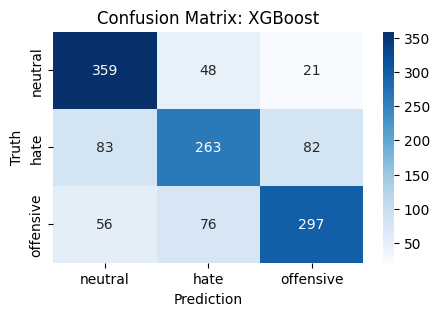

Training SVM...

SVM Accuracy: 0.71

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       428
           1       0.70      0.60      0.65       428
           2       0.71      0.70      0.71       429

    accuracy                           0.71      1285
   macro avg       0.71      0.71      0.71      1285
weighted avg       0.71      0.71      0.71      1285



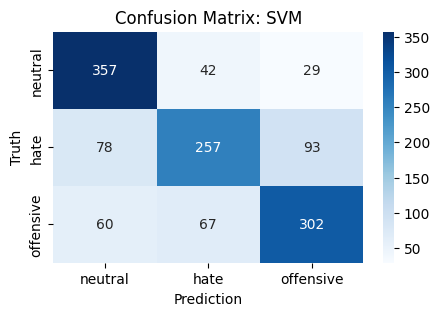

In [19]:
from GoingModular.ModelTrainer import ModelTrainer

trainer = ModelTrainer(df=df_vectorized)
trainer.ModelPreparing()

# 4. Main Workflow

In [ ]:
# Define the main workflow function

def MainWorkflow():
  # Step 1: Download and load the data
  data_manager = DataManager(data_path="Data", file_name="hate_speech.csv")
  data_manager.download_data(url="https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv")
  data_manager.load_data()

  # Step 2: Preprocess the data
  preprocessor = TextPreprocessor()
  data_manager.raw_df["Text"] = data_manager.raw_df["Text"].apply(preprocessor.preprocess)

  # Step 3: Vectorize the text data
  vectorizer = Vectorizer(pretrain_wv=pretrain_wv)
  df_vectorized = vectorizer.vectorize(data_manager.raw_df)

  # Step 4: Train and evaluate models
  trainer = ModelTrainer(df=df_vectorized)
  trainer.ModelPreparing()

# Call the main function
if __name__ == "__main__":
    MainWorkflow()